Generate plots based on spike_trains_tau100ms_alpha0_3_fr3_5hz_len600sec_var_duration.pkl.

Duration is between 2s - 600sec, 10000 spike trains.

In [1]:
import numpy as np
import pandas as pd
import pickle

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'results\\synthetic\\dataset\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\fixed_params_var_duration\\'
fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper\\'

In [29]:
save_fig = True

### Load data

In [4]:
with open(dataset_folder + '2_spike_trains_tau100ms_alpha0_3_fr3_5hz_var_duration.pkl', 'rb') as f:
    dataset = pickle.load(f)

duration_ms_all = dataset['duration_ms']
fr_values = dataset['fr_values']
alphas = dataset['alphas']
taus_ms = dataset['tau_ms']


with open(results_folder + 'acf_isttc_full_50ms_20lags_dict.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(results_folder + 'acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')

len isttc_full_dict 10000
len acf_full_dict 10000


### Make summary dfs

In [5]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [6]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [11]:
# Generate 20 log spaced floats between 2 and 600
values = np.logspace(np.log10(2), np.log10(600), num=11)
edges_int = np.round(values).astype(int)
# interval labels for df column
labels = [f"interval_{edges_int[i]}_{edges_int[i+1]}" for i in range(len(edges_int)-1)]

In [13]:
edges_int

array([  2,   4,   6,  11,  20,  35,  61, 108, 192, 339, 600])

In [14]:
data = []
for unit_id, unit_data in acf_full_dict.items():
    taus = unit_data['taus']  
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_full_plot_df = pd.DataFrame(data)
acf_full_plot_df['method'] = 'acf_full'
acf_full_plot_df['tau_ms'] = acf_full_plot_df['tau'] * 50

acf_full_plot_df['duration_ms'] = duration_ms_all
acf_full_plot_df['duration_s'] = acf_full_plot_df['duration_ms'] / 1000

acf_full_plot_df['fr'] = fr_values
acf_full_plot_df['alpha'] = alphas
acf_full_plot_df['tau_ms_true'] = taus_ms
acf_full_plot_df['tau_diff_abs'] = np.abs(acf_full_plot_df['tau_ms'] - acf_full_plot_df['tau_ms_true'])
acf_full_plot_df['tau_diff_rel'] = acf_full_plot_df['tau_diff_abs'] / acf_full_plot_df['tau_ms_true'] * 100

acf_full_plot_df['dur_interval'] = pd.cut(
    acf_full_plot_df['duration_s'],
    bins=edges_int,
    labels=labels,
    right=False  # intervals are [left, right)
)

rows_with_nans_df = acf_full_plot_df[acf_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')
acf_full_plot_df['method'] = 'acf_full'

acf_full_plot_df.head(2)

N rows with NaNs 0


,unit_id,tau,fit_r_squared,decline_150_250,method,tau_ms,duration_ms,duration_s,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,dur_interval
0,0,1.037169,0.468732,True,acf_full,51.858430,55372,55.372,3.5,0.3,100.0,48.141570,48.141570,interval_35_61
1,1,1.722380,0.954526,True,acf_full,86.118992,464826,464.826,3.5,0.3,100.0,13.881008,13.881008,interval_339_600


In [15]:
data = []
for unit_id, unit_data in isttc_full_dict.items():
    taus = unit_data['taus']      
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
isttc_full_plot_df = pd.DataFrame(data)
isttc_full_plot_df['method'] = 'isttc_full'
isttc_full_plot_df['tau_ms'] = isttc_full_plot_df['tau'] * 50

isttc_full_plot_df['duration_ms'] = duration_ms_all
isttc_full_plot_df['duration_s'] = isttc_full_plot_df['duration_ms'] / 1000

isttc_full_plot_df['fr'] = fr_values
isttc_full_plot_df['alpha'] = alphas
isttc_full_plot_df['tau_ms_true'] = taus_ms
isttc_full_plot_df['tau_diff_abs'] = np.abs(isttc_full_plot_df['tau_ms'] - isttc_full_plot_df['tau_ms_true'])
isttc_full_plot_df['tau_diff_rel'] = isttc_full_plot_df['tau_diff_abs'] / isttc_full_plot_df['tau_ms_true'] * 100

isttc_full_plot_df['dur_interval'] = pd.cut(
    isttc_full_plot_df['duration_s'],
    bins=edges_int,
    labels=labels,
    right=False  # intervals are [left, right)
)

rows_with_nans_df = isttc_full_plot_df[isttc_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')

isttc_full_plot_df['method'] = 'isttc_full'
isttc_full_plot_df.head(2)

N rows with NaNs 0


,unit_id,tau,fit_r_squared,decline_150_250,method,tau_ms,duration_ms,duration_s,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,dur_interval
0,0,1.067646,0.503055,True,isttc_full,53.382302,55372,55.372,3.5,0.3,100.0,46.617698,46.617698,interval_35_61
1,1,1.572777,0.955250,True,isttc_full,78.638873,464826,464.826,3.5,0.3,100.0,21.361127,21.361127,interval_339_600


In [16]:
# check for NaNs 

rows_with_nans_acf_df = acf_full_plot_df[acf_full_plot_df.isna().any(axis=1)]
n_rows_with_nan_acf = len(rows_with_nans_acf_df)
print(f'N rows with NaNs {n_rows_with_nan_acf}')

rows_with_nans_isttc_df = isttc_full_plot_df[isttc_full_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc = len(rows_with_nans_isttc_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc}')

# take from isttc dataset only rows where acf df has no NaNs
isttc_full_plot_df = isttc_full_plot_df[~isttc_full_plot_df['unit_id'].isin(rows_with_nans_acf_df['unit_id'].values)]
acf_full_plot_df = acf_full_plot_df[~acf_full_plot_df['unit_id'].isin(rows_with_nans_acf_df['unit_id'].values)]

print(f'len acf_full_plot_df {len(acf_full_plot_df)}, len isttc_full_plot_df {len(isttc_full_plot_df)}')

N rows with NaNs 0
N rows with NaNs 0
len acf_full_plot_df 10000, len isttc_full_plot_df 10000


In [17]:
# check for negative R-square

rows_with_negr_acf_df = acf_full_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_acf = len(rows_with_negr_acf_df)
print(f'N rows with neg R {n_rows_with_negr_acf}')


rows_with_negr_isttc_df = isttc_full_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc = len(rows_with_negr_isttc_df)
print(f'N rows with neg R {n_rows_with_negr_isttc}')

acf_negr_unit_ids = rows_with_negr_acf_df['unit_id'].values
isttc_negr_unit_ids = rows_with_negr_isttc_df['unit_id'].values

unit_ids_negr_union = set(acf_negr_unit_ids).union(isttc_negr_unit_ids)
print(f'N rows in unit_ids_negr_union {len(unit_ids_negr_union)}')

isttc_full_plot_df = isttc_full_plot_df[~isttc_full_plot_df['unit_id'].isin(unit_ids_negr_union)]
acf_full_plot_df = acf_full_plot_df[~acf_full_plot_df['unit_id'].isin(unit_ids_negr_union)]

print(f'len acf_full_plot_df {len(acf_full_plot_df)}, len isttc_full_plot_df {len(isttc_full_plot_df)}')

N rows with neg R 32
N rows with neg R 43
N rows in unit_ids_negr_union 52
len acf_full_plot_df 9948, len isttc_full_plot_df 9948


In [18]:
tau_plot_long_df = pd.concat([acf_full_plot_df, isttc_full_plot_df])
tau_plot_long_df.reset_index(inplace=True, drop=True)

print(f'len tau_plot_long_df {len(tau_plot_long_df)}')

len tau_plot_long_df 19896


In [19]:
tau_plot_wide_df = acf_full_plot_df.merge(isttc_full_plot_df, suffixes=('_acf', '_isttc'), 
                                          on=['unit_id','fr', 'alpha', 'tau_ms_true', 'duration_ms', 'duration_s', 'dur_interval'], 
                                          how='left')
tau_plot_wide_df.reset_index(inplace=True, drop=True)

print(f'len tau_plot_wide_df {len(tau_plot_wide_df)}')

tau_plot_wide_df.columns

len tau_plot_wide_df 9948


Index(['unit_id', 'tau_acf', 'fit_r_squared_acf', 'decline_150_250_acf',
       'method_acf', 'tau_ms_acf', 'duration_ms', 'duration_s', 'fr', 'alpha',
       'tau_ms_true', 'tau_diff_abs_acf', 'tau_diff_rel_acf', 'dur_interval',
       'tau_isttc', 'fit_r_squared_isttc', 'decline_150_250_isttc',
       'method_isttc', 'tau_ms_isttc', 'tau_diff_abs_isttc',
       'tau_diff_rel_isttc'],
      dtype='object')

### Export for stats

In [ ]:
tau_plot_long_df.to_csv(results_folder + 'tau_plot_long_df.csv')

### Plots

In [20]:
color_acf_full = '#708090' # slate gray
color_isttc_full = '#00A9E2' # steel blue

In [ ]:
# just to check, I plot the same as predicted values from the model
fig, axes = plt.subplots(1,1, figsize=(5, 3), sharey=False)

sns.regplot(x=tau_plot_wide_df['duration_s'].values, y=np.log10(tau_plot_wide_df['tau_diff_rel_acf']), scatter=None, ax=axes, 
            label='acf_full', color=color_acf_full)
sns.regplot(x=tau_plot_wide_df['duration_s'].values, y=np.log10(tau_plot_wide_df['tau_diff_rel_isttc']), scatter=None, ax=axes, 
            label='isttc_full', color=color_isttc_full)
axes.legend(frameon=False)

axes.set_xlabel('Firing rate (Hz)')

# for ax in axes.flat:
#     ax.set_ylabel('Log10 diff(IT, \nground truth) (ms)')

sns.despine()

# if save_fig:
#     plt.savefig(fig_folder + 'taus_dataset_duration_var_diff_regplot.png' , bbox_inches='tight', dpi=300)
#     plt.savefig(fig_folder + 'taus_dataset_duration_var_diff_regplot.svg' , bbox_inches='tight')

In [21]:
# intervals for error plots
intervals = {
    '+-100':   (0,   200),
    '+-75':  (25,  175),
    '+-50':  (50,  150),
    '+-25':  (75,  125),
}

tau_2methods_df = pd.concat([acf_full_plot_df, isttc_full_plot_df])
tau_2methods_df['log_tau_ms'] = np.log10(tau_2methods_df['tau_ms'])
tau_2methods_df.reset_index(inplace=True, drop=True)

df = tau_2methods_df.copy()
rows = []
for method, sub in df.groupby(by=['method','dur_interval']):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_ms'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)
tau_2methods_error_df = pd.DataFrame(rows).set_index('method')

# make long df
tau_2methods_error_df = tau_2methods_error_df.reset_index()
tau_2methods_error_long_df = tau_2methods_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)

tau_2methods_error_long_df[['method','dur_interval']] = pd.DataFrame(
    tau_2methods_error_long_df['method'].tolist(),
    index=tau_2methods_error_long_df.index
)
tau_2methods_error_long_df = tau_2methods_error_long_df.rename(columns={'interval':'error_interval'})
tau_2methods_error_long_df = tau_2methods_error_long_df[['method','dur_interval','error_interval','percentage']]

C:\Users\ipochino\AppData\Local\Temp\ipykernel_6244\3513360574.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for method, sub in df.groupby(by=['method','dur_interval']):


In [22]:
# prep for heatmaps
# ACF
acf = tau_2methods_error_long_df[
    tau_2methods_error_long_df['method']=='acf_full'
]
acf_pivot = acf.pivot(
    index='dur_interval',
    columns='error_interval',
    values='percentage'
)

# ISTTC
isttc = tau_2methods_error_long_df[
    tau_2methods_error_long_df['method']=='isttc_full'
]
isttc_pivot = isttc.pivot(
    index='dur_interval',
    columns='error_interval',
    values='percentage'
)

diff_pivot = acf_pivot-isttc_pivot

-12.903225806451609
5.555555555555557


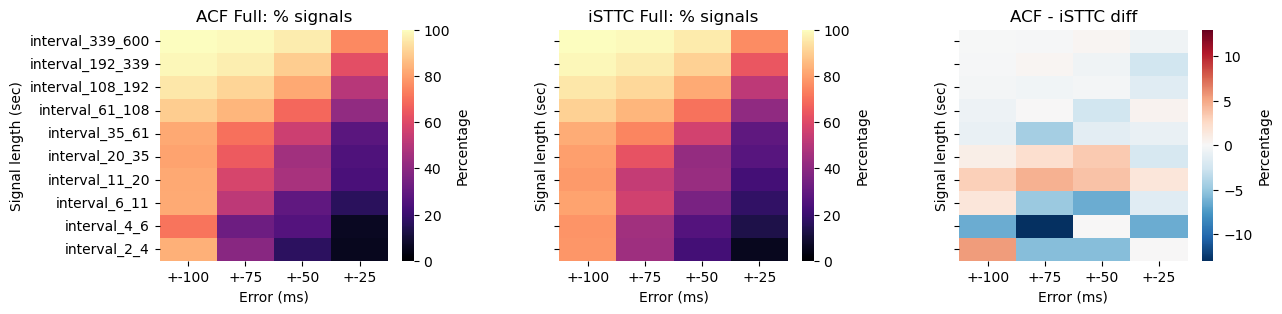

In [30]:
col_order = ['+-100', '+-75', '+-50', '+-25']
def lower_bound(label):
    return int(label.split('_')[1])
row_order = sorted(acf_pivot.index, key=lower_bound, reverse=True)

acf_ordered  = acf_pivot.reindex(index=row_order, columns=col_order)
isttc_ordered  = isttc_pivot.reindex(index=row_order, columns=col_order)
diff_pivot_ordered  = diff_pivot.reindex(index=row_order, columns=col_order)

# plot ACF heatmap
fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

norm = TwoSlopeNorm(vcenter=0, vmin=-13, vmax=13)
#norm = TwoSlopeNorm(vcenter=0)

sns.heatmap(
    acf_ordered,
    cmap="magma", vmin=0, vmax=100,
    cbar_kws={'label': 'Percentage'}, 
    ax=axes[0]
)
axes[0].set_title("ACF Full: % signals")

sns.heatmap(
    isttc_ordered,
    cmap="magma", vmin=0, vmax=100,
    cbar_kws={'label': 'Percentage'}, 
    ax=axes[1]
)
axes[1].set_title('iSTTC Full: % signals')

sns.heatmap(
    diff_pivot_ordered,
    cmap="RdBu_r", #"coolwarm", 
    norm=norm,
    cbar_kws={'label': 'Percentage'}, 
    ax=axes[2]
)
axes[2].set_title('ACF - iSTTC diff')
print(diff_pivot_ordered.min().min())
print(diff_pivot_ordered.max().max())

for ax in axes.flat:
    ax.set_xlabel('Error (ms)')
    ax.set_ylabel('Signal length (sec)')
if save_fig:
    plt.savefig(fig_folder + 'taus_dataset_duration_var_heatmaps_colors2.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_dataset_duration_var_heatmaps_colors2.svg' , bbox_inches='tight')